In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
print(os.listdir(('/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/train/images/')))

['class 0', 'class 1']


In [ ]:
!pip install torch torchvision opencv-python
!pip install scikit-plot
!pip install django-model-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 24.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.0MB/s]


Epoch [1/5], Train Accuracy: 71.27%, Test Accuracy: 57.14%
Epoch [2/5], Train Accuracy: 79.19%, Test Accuracy: 54.29%
Epoch [3/5], Train Accuracy: 71.37%, Test Accuracy: 60.00%
Epoch [4/5], Train Accuracy: 74.72%, Test Accuracy: 60.00%
Epoch [5/5], Train Accuracy: 90.96%, Test Accuracy: 51.43%
Acurácia: 0.5142857142857142
Precisão: 0.38461538461538464
Recall: 0.35714285714285715
F1-score: 0.3703703703703704
True Negative (TN): 13
False Positive (FP): 8
False Negative (FN): 9
True Positive (TP): 5


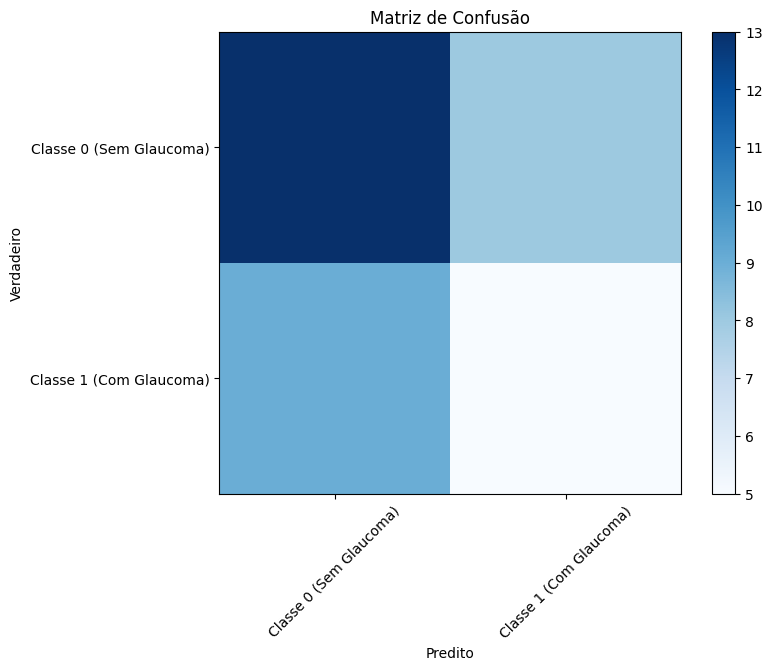

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.59      0.62      0.60        21
Classe 1 (Com Glaucoma)       0.38      0.36      0.37        14

               accuracy                           0.51        35
              macro avg       0.49      0.49      0.49        35
           weighted avg       0.51      0.51      0.51        35



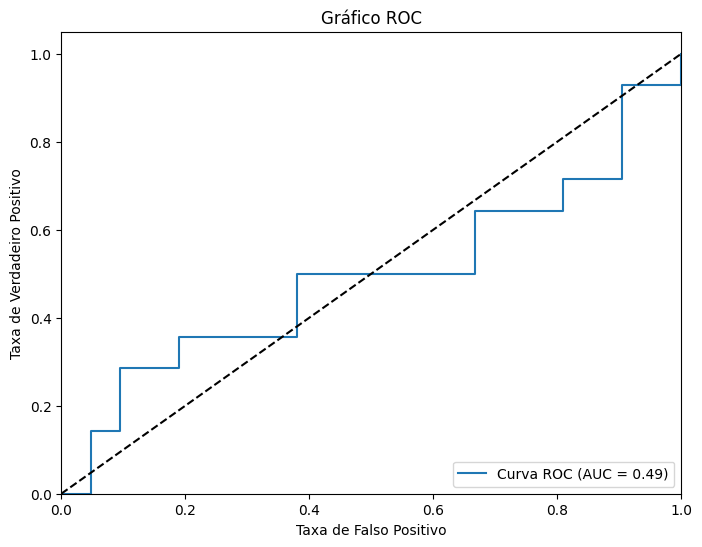

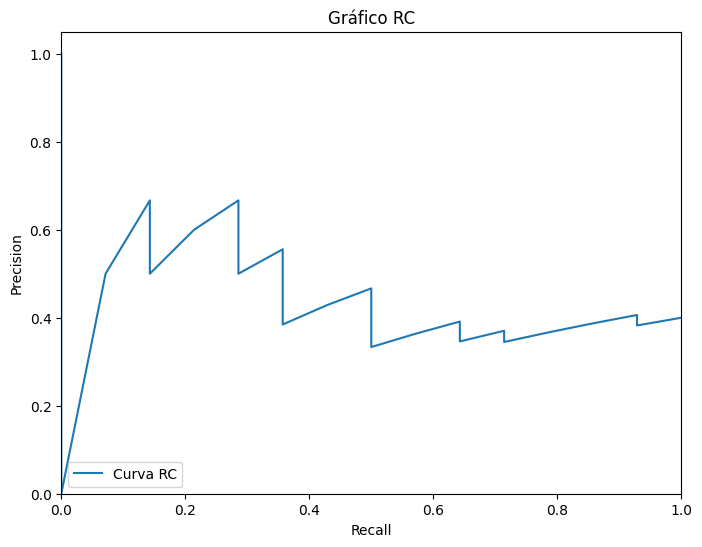

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.59      0.62      0.60        21
Classe 1 (Com Glaucoma)       0.38      0.36      0.37        14

               accuracy                           0.51        35
              macro avg       0.49      0.49      0.49        35
           weighted avg       0.51      0.51      0.51        35



In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Função para carregar as imagens e anotações
def load_data(root_dir):
    image_dir_train = os.path.join(root_dir, 'train/images')
    annotation_dir_train = os.path.join(root_dir, 'train/anotacoes')
    image_dir_test = os.path.join(root_dir, 'valid/images')
    annotation_dir_test = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(
        root=image_dir_train,
        transform=transform
    )

    test_data = torchvision.datasets.ImageFolder(
        root=image_dir_test,
        transform=transform
    )

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=16,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=16,
        shuffle=False
    )

    return train_loader, test_loader


def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy



def train_model(train_loader, test_loader, num_epochs=5):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Two classes: 0 (without glaucoma) and 1 (with glaucoma)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0  # Track the best test accuracy
    train_accuracies = []  # List to store train accuracies

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the test set
        test_accuracy = evaluate_model(model, test_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2%}, Test Accuracy: {test_accuracy:.2%}')

        # Save the best model based on the highest test accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model_state = model.state_dict()

    # Save the best model checkpoint
    torch.save(best_model_state, 'best_model.pth')

    return model


def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo de execução
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Obter as probabilidades de saída (scores)
            scores = F.softmax(outputs, dim=1)
            y_scores.extend(scores[:, 1].cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    class_names = ['Classe 0 (Sem Glaucoma)', 'Classe 1 (Com Glaucoma)']

    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular as estatísticas ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot do gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Gráfico ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular as estatísticas RC
    precision, recall, thresholds_rc = precision_recall_curve(y_true, y_scores)

    # Plot do gráfico RC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Curva RC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Gráfico RC')
    plt.legend(loc='lower left')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))


# Caminho para o diretório raiz contendo as pastas 'train' e 'valid'
root_dir = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"

train_loader, test_loader = load_data(root_dir)
model = train_model(train_loader, test_loader)
test_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Train Accuracy: 72.69%, Loss: 0.7742
Epoch [2/5], Train Accuracy: 72.28%, Loss: 0.5502
Epoch [3/5], Train Accuracy: 77.06%, Loss: 0.4412
Epoch [4/5], Train Accuracy: 90.76%, Loss: 0.2769
Epoch [5/5], Train Accuracy: 96.75%, Loss: 0.1626
Acurácia: 0.42857142857142855
Precisão: 0.125
Recall: 0.07142857142857142
F1-score: 0.09090909090909091
True Negative (TN): 14
False Positive (FP): 7
False Negative (FN): 13
True Positive (TP): 1


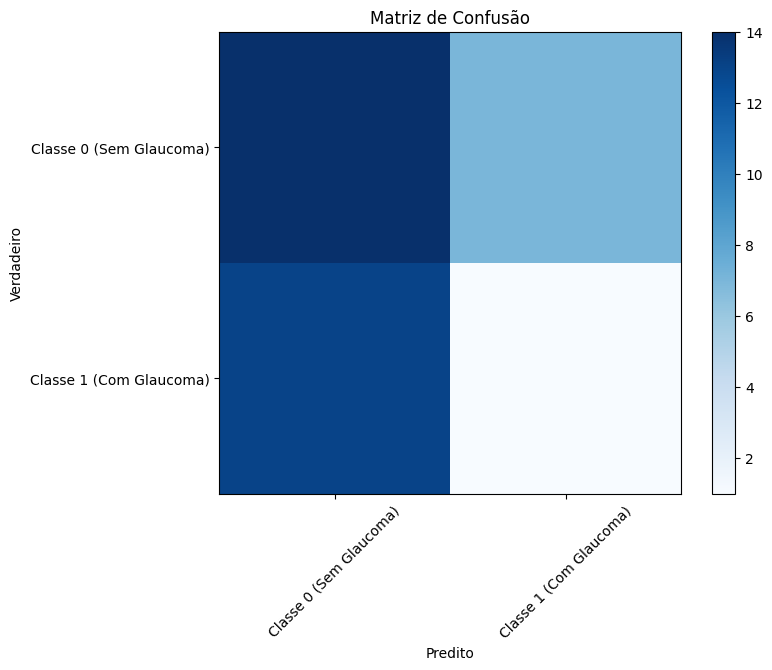

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.52      0.67      0.58        21
Classe 1 (Com Glaucoma)       0.12      0.07      0.09        14

               accuracy                           0.43        35
              macro avg       0.32      0.37      0.34        35
           weighted avg       0.36      0.43      0.39        35



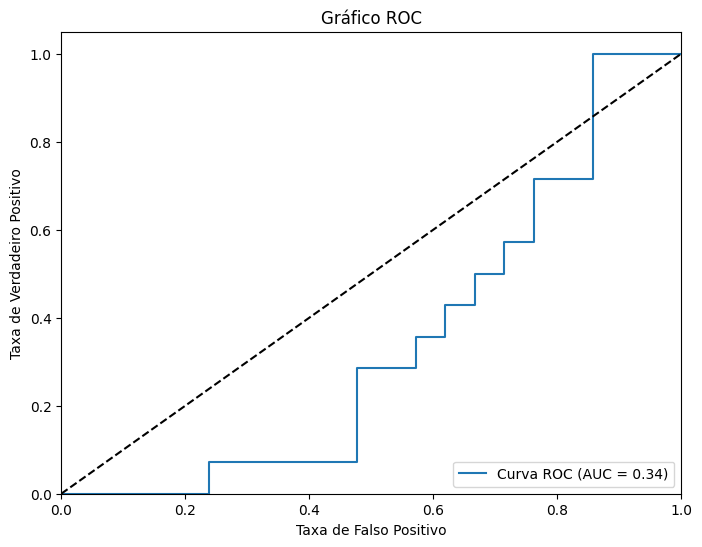

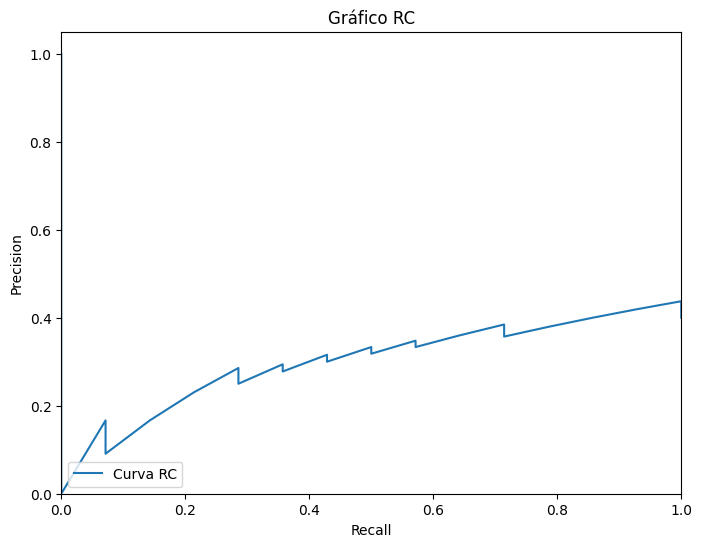

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.52      0.67      0.58        21
Classe 1 (Com Glaucoma)       0.12      0.07      0.09        14

               accuracy                           0.43        35
              macro avg       0.32      0.37      0.34        35
           weighted avg       0.36      0.43      0.39        35



In [ ]:
#Resnet novo

import os
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Função para carregar as imagens e anotações
def load_data(root_dir):
    image_dir_train = os.path.join(root_dir, 'train/images')
    annotation_dir_train = os.path.join(root_dir, 'train/anotacoes')


    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(
        root=image_dir_train,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=16,
        shuffle=True
    )
    return train_loader

def test_load_data(root_dir):
    image_dir_test = os.path.join(root_dir, 'valid/images')
    annotation_dir_test = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])
    test_data = torchvision.datasets.ImageFolder(
        root=image_dir_test,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=16,
        shuffle=False
    )

    return test_loader

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy



def train_model(train_loader, num_epochs=5):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Two classes: 0 (without glaucoma) and 1 (with glaucoma)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0  # Track the best test accuracy
    train_accuracies = []  # List to store train accuracies
    train_losses = []  # List to store train losses

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2%}, Loss: {epoch_loss:.4f}')

        # Save the best model based on the highest test accuracy
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            best_model_state = model.state_dict()

    # Save the best model checkpoint
    torch.save(best_model_state, 'best_model.pth')

    return model


def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo de execução
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Obter as probabilidades de saída (scores)
            scores = F.softmax(outputs, dim=1)
            y_scores.extend(scores[:, 1].cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    class_names = ['Classe 0 (Sem Glaucoma)', 'Classe 1 (Com Glaucoma)']

    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular as estatísticas ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot do gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Gráfico ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular as estatísticas RC
    precision, recall, thresholds_rc = precision_recall_curve(y_true, y_scores)

    # Plot do gráfico RC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Curva RC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Gráfico RC')
    plt.legend(loc='lower left')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))


# Load data
root_dir = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
train_loader = load_data(root_dir)  # Test loader is not needed during training

# Train the model
num_epochs = 5  # You can adjust this value as needed
model = train_model(train_loader, num_epochs)

# Load the best model checkpoint for testing
best_model_state = torch.load('best_model.pth')
model.load_state_dict(best_model_state)

# Load and set up the test data
test_loader = test_load_data(root_dir)  # Define the load_test_data function similar to load_data, but for test data

# Test the model
test_model(model, test_loader)

In [ ]:
#Resnet novo COM VALIDAÇÃO

import os
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Função para carregar as imagens e anotações
def load_data(root_dir):
    image_dir_train = os.path.join(root_dir, 'train/images')
    annotation_dir_train = os.path.join(root_dir, 'train/anotacoes')


    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(
        root=image_dir_train,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=16,
        shuffle=True
    )
    return train_loader

def test_load_data(root_dir):
    image_dir_test = os.path.join(root_dir, 'valid/images')
    annotation_dir_test = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])
    test_data = torchvision.datasets.ImageFolder(
        root=image_dir_test,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=16,
        shuffle=False
    )

    return test_loader

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def val_model(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def train_model(train_loader, num_epochs=5):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Two classes: 0 (without glaucoma) and 1 (with glaucoma)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_val_accuracy = 0.0  # Track the best validation accuracy
    val_accuracies = []  # List to store validation accuracies

    best_accuracy = 0.0  # Track the best test accuracy
    train_accuracies = []  # List to store train accuracies
    train_losses = []  # List to store train losses

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2%}, Loss: {epoch_loss:.4f}')

        # Save the best model based on the highest test accuracy
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            best_model_state = model.state_dict()

    # Validation after training
    model.eval()
    val_accuracy = evaluate_model(model, val_loader)
    val_accuracies.append(val_accuracy)

    print(f'Training Finished, Validation Accuracy: {val_accuracy:.2%}')
    # Save the best model based on the highest validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

    # Save the best model checkpoint
    torch.save(best_model_state, 'best_model.pth')

    return model


def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo de execução
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Obter as probabilidades de saída (scores)
            scores = F.softmax(outputs, dim=1)
            y_scores.extend(scores[:, 1].cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    class_names = ['Classe 0 (Sem Glaucoma)', 'Classe 1 (Com Glaucoma)']

    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular as estatísticas ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot do gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Gráfico ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular as estatísticas RC
    precision, recall, thresholds_rc = precision_recall_curve(y_true, y_scores)

    # Plot do gráfico RC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Curva RC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Gráfico RC')
    plt.legend(loc='lower left')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))


# Load data
root_dir = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
num_epochs = 5  # You can adjust this value as needed
# Load validation data
val_loader = test_load_data(root_dir)

# Train the model with validation
model = train_model(train_loader, num_epochs)

# Load the best model checkpoint for testing
best_model_state = torch.load('best_model.pth')
model.load_state_dict(best_model_state)

# Test the model
test_loader = test_load_data(root_dir)
test_model(model, test_loader)

NameError: ignored

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.8MB/s]


Epoch [1/5], Train Accuracy: 73.40%, Validation Accuracy: 62.86%, Loss: 0.6660
Epoch [2/5], Train Accuracy: 66.09%, Validation Accuracy: 48.57%, Loss: 0.5517
Epoch [3/5], Train Accuracy: 83.25%, Validation Accuracy: 51.43%, Loss: 0.4283
Epoch [4/5], Train Accuracy: 76.85%, Validation Accuracy: 60.00%, Loss: 0.2402
Epoch [5/5], Train Accuracy: 88.43%, Validation Accuracy: 54.29%, Loss: 0.1552
Acurácia: 0.5428571428571428
Precisão: 0.3333333333333333
Recall: 0.14285714285714285
F1-score: 0.2
True Negative (TN): 17
False Positive (FP): 4
False Negative (FN): 12
True Positive (TP): 2


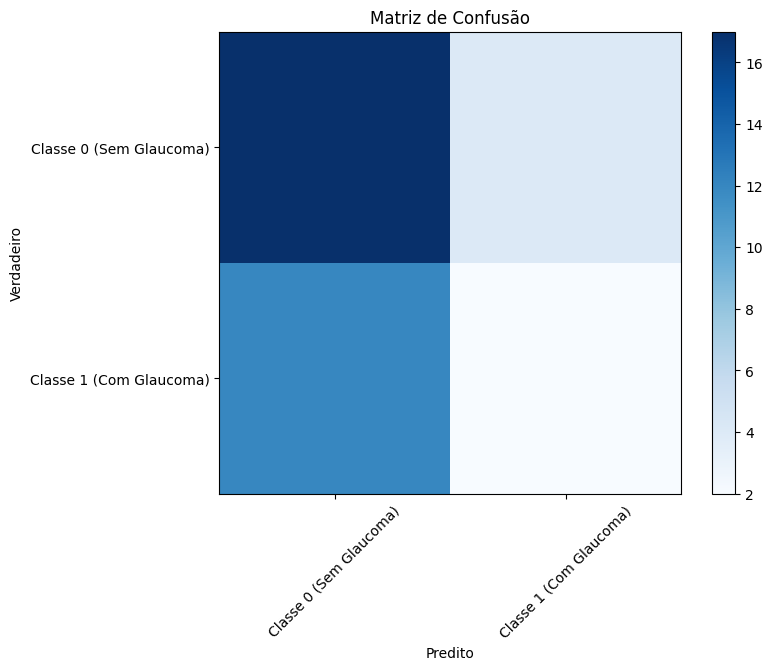

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.59      0.81      0.68        21
Classe 1 (Com Glaucoma)       0.33      0.14      0.20        14

               accuracy                           0.54        35
              macro avg       0.46      0.48      0.44        35
           weighted avg       0.49      0.54      0.49        35



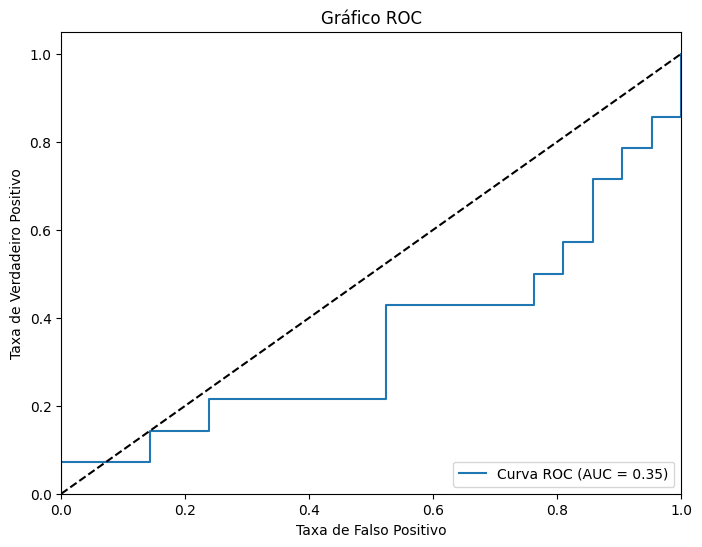

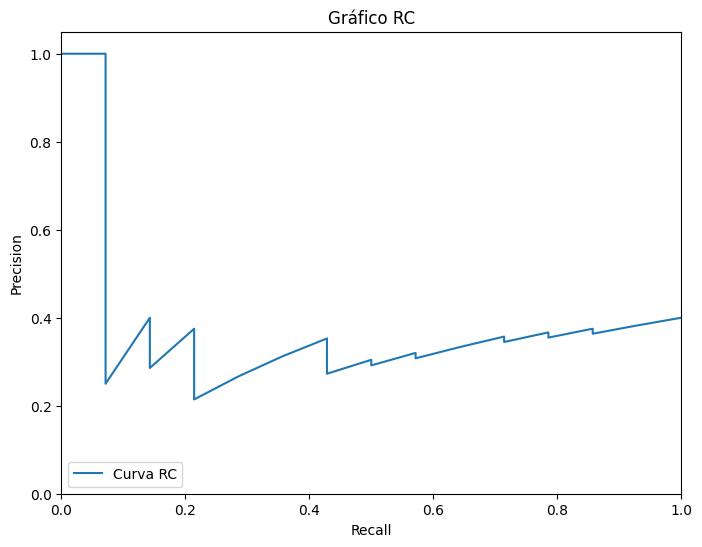

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.59      0.81      0.68        21
Classe 1 (Com Glaucoma)       0.33      0.14      0.20        14

               accuracy                           0.54        35
              macro avg       0.46      0.48      0.44        35
           weighted avg       0.49      0.54      0.49        35



In [ ]:
#Resnet novo COM VALIDAÇÃO como função e caminho adequado

import os
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Função para carregar as imagens e anotações
def load_data(root_dir):
    image_dir_train = os.path.join(root_dir, 'train/images')
    annotation_dir_train = os.path.join(root_dir, 'train/anotacoes')


    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(
        root=image_dir_train,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=16,
        shuffle=True
    )
    return train_loader

def test_load_data(root_dir):
    image_dir_test = os.path.join(root_dir, 'valid/images')
    annotation_dir_test = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])
    test_data = torchvision.datasets.ImageFolder(
        root=image_dir_test,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=16,
        shuffle=False
    )

    return test_loader

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def validation_load_data(valid_dir):
    image_dir_val = os.path.join(root_dir, 'valid/images')
    annotation_dir_val = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    val_data = torchvision.datasets.ImageFolder(
        root=image_dir_val,
        transform=transform
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=16,
        shuffle=False
    )

    return val_loader

def train_model(train_loader, val_loader, num_epochs=5):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0  # Track the best test accuracy
    train_accuracies = []  # List to store train accuracies
    train_losses = []  # List to store train losses

    best_val_accuracy = 0.0  # Track the best validation accuracy
    val_accuracies = []  # List to store validation accuracies



    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        # Validation after each epoch
        model.eval()
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2%}, Validation Accuracy: {val_accuracy:.2%}, Loss: {epoch_loss:.4f}')

        # Save the best model based on the highest validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

    # Save the best model checkpoint
    torch.save(best_model_state, 'G1020best_model.pth')

    return model


def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo de execução
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Obter as probabilidades de saída (scores)
            scores = F.softmax(outputs, dim=1)
            y_scores.extend(scores[:, 1].cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    class_names = ['Classe 0 (Sem Glaucoma)', 'Classe 1 (Com Glaucoma)']

    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular as estatísticas ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot do gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Gráfico ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular as estatísticas RC
    precision, recall, thresholds_rc = precision_recall_curve(y_true, y_scores)

    # Plot do gráfico RC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Curva RC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Gráfico RC')
    plt.legend(loc='lower left')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))


# Load data
root_dir = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
train_loader = load_data(root_dir)

# Load validation data
val_root_dir = "/content/drive/MyDrive/compara_segmentadores/data2/talho/ORIGA/"
val_loader = validation_load_data(val_root_dir)

# Train the model with validation
num_epochs = 5
model = train_model(train_loader, val_loader, num_epochs)

# Load the best model checkpoint for testing
best_model_state = torch.load('best_model.pth')
model.load_state_dict(best_model_state)

# Load and set up the test data
test_loader = test_load_data(root_dir)

# Test the model
test_model(model, test_loader)

Epoch [1/5], Train Accuracy: 75.23%, Validation Accuracy: 39.13%, Loss: 0.6824
Epoch [2/5], Train Accuracy: 71.88%, Validation Accuracy: 47.83%, Loss: 0.5811
Epoch [3/5], Train Accuracy: 87.72%, Validation Accuracy: 47.83%, Loss: 0.4239
Epoch [4/5], Train Accuracy: 94.92%, Validation Accuracy: 56.52%, Loss: 0.2694
Epoch [5/5], Train Accuracy: 79.19%, Validation Accuracy: 47.83%, Loss: 0.1613
Acurácia: 0.5428571428571428
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
True Negative (TN): 19
False Positive (FP): 2
False Negative (FN): 14
True Positive (TP): 0


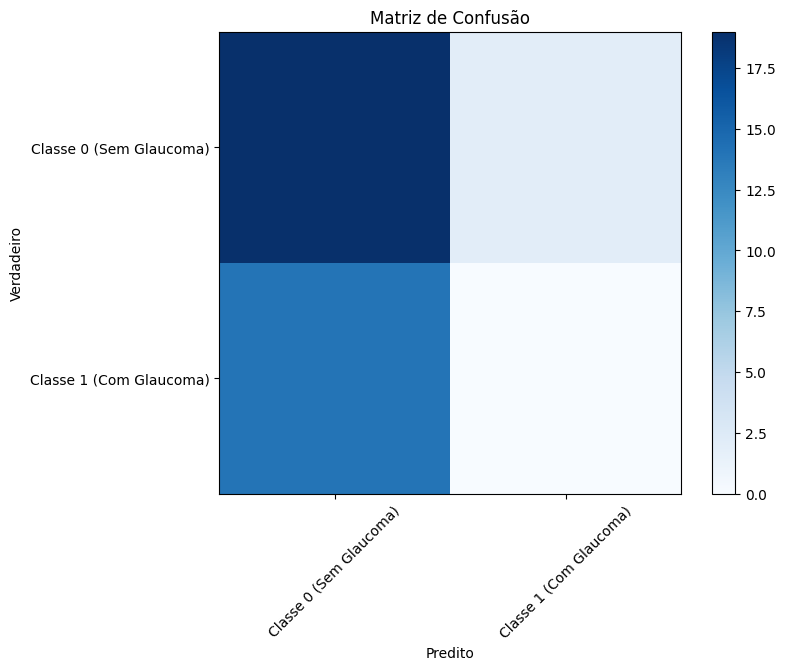

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.58      0.90      0.70        21
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        14

               accuracy                           0.54        35
              macro avg       0.29      0.45      0.35        35
           weighted avg       0.35      0.54      0.42        35



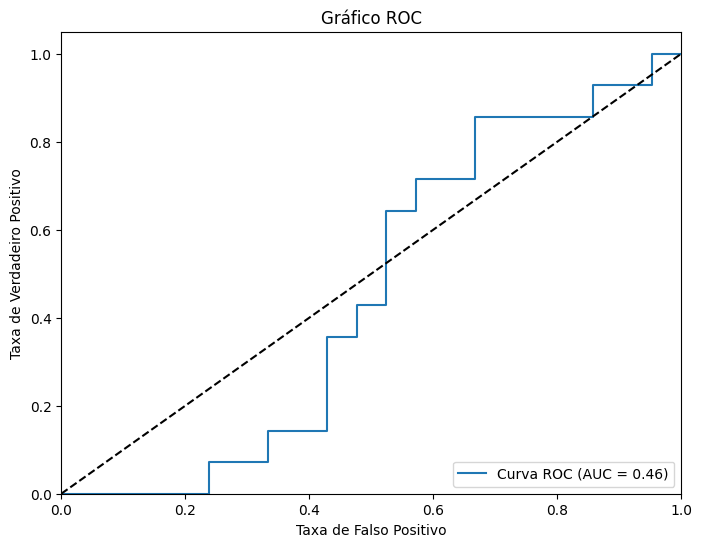

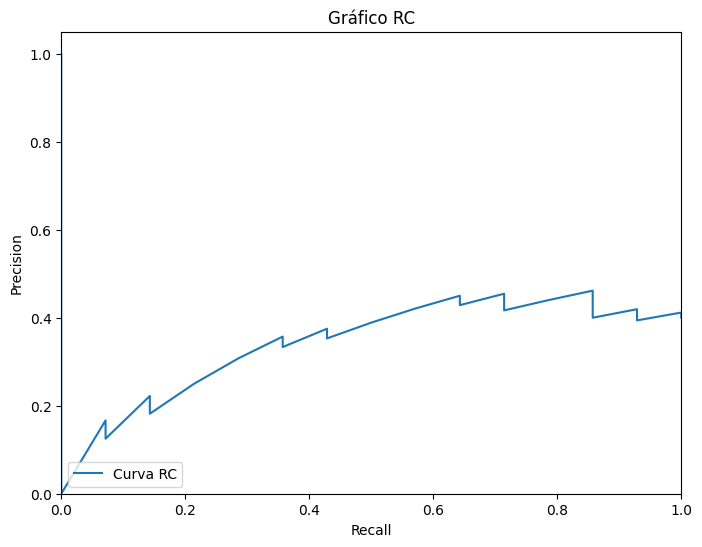

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.58      0.90      0.70        21
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        14

               accuracy                           0.54        35
              macro avg       0.29      0.45      0.35        35
           weighted avg       0.35      0.54      0.42        35



In [ ]:
#Resnet novo COM VALIDAÇÃO como função e caminho adequado

import os
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Função para carregar as imagens e anotações
def load_data(root_dir):
    image_dir_train = os.path.join(root_dir, 'train/images')
    annotation_dir_train = os.path.join(root_dir, 'train/anotacoes')


    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(
        root=image_dir_train,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=16,
        shuffle=True
    )
    return train_loader

def test_load_data(root_dir):
    image_dir_test = os.path.join(root_dir, 'valid/images')
    annotation_dir_test = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])
    test_data = torchvision.datasets.ImageFolder(
        root=image_dir_test,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=16,
        shuffle=False
    )

    return test_loader

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def validation_load_data(valid_dir):
    image_dir_val = os.path.join(root_dir, 'valid/images')
    annotation_dir_val = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    val_data = torchvision.datasets.ImageFolder(
        root=image_dir_val,
        transform=transform
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=16,
        shuffle=False
    )

    return val_loader

def train_model(train_loader, val_loader, num_epochs=5):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0  # Track the best test accuracy
    train_accuracies = []  # List to store train accuracies
    train_losses = []  # List to store train losses

    best_val_accuracy = 0.0  # Track the best validation accuracy
    val_accuracies = []  # List to store validation accuracies



    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        # Validation after each epoch
        model.eval()
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2%}, Validation Accuracy: {val_accuracy:.2%}, Loss: {epoch_loss:.4f}')

        # Save the best model based on the highest validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

    # Save the best model checkpoint
    torch.save(best_model_state, 'G1020best_model.pth')

    return model


def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo de execução
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Obter as probabilidades de saída (scores)
            scores = F.softmax(outputs, dim=1)
            y_scores.extend(scores[:, 1].cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    class_names = ['Classe 0 (Sem Glaucoma)', 'Classe 1 (Com Glaucoma)']

    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular as estatísticas ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot do gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Gráfico ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular as estatísticas RC
    precision, recall, thresholds_rc = precision_recall_curve(y_true, y_scores)

    # Plot do gráfico RC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Curva RC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Gráfico RC')
    plt.legend(loc='lower left')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))


# Load data
root_dir = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
train_loader = load_data(root_dir)

# Load validation data
val_root_dir = "/content/drive/MyDrive/compara_segmentadores/data2/talho/ORIGA/"
val_loader = validation_load_data(val_root_dir)

# Train the model with validation
num_epochs = 5
model = train_model(train_loader, val_loader, num_epochs)

# Load the best model checkpoint for testing
best_model_state = torch.load('best_model.pth')
model.load_state_dict(best_model_state)

# Load and set up the test data
test_loader = test_load_data(root_dir)

# Test the model
test_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.4MB/s]


Epoch [1/3], Train Accuracy: 72.89%, Validation Accuracy: 78.33%, Loss: 0.6505
Epoch [2/3], Train Accuracy: 83.65%, Validation Accuracy: 60.00%, Loss: 0.5390
Epoch [3/3], Train Accuracy: 84.06%, Validation Accuracy: 43.89%, Loss: 0.4040
Acurácia: 0.8266666666666667
Precisão: 0.4772727272727273
Recall: 0.42
F1-score: 0.4468085106382979
True Negative (TN): 227
False Positive (FP): 23
False Negative (FN): 29
True Positive (TP): 21


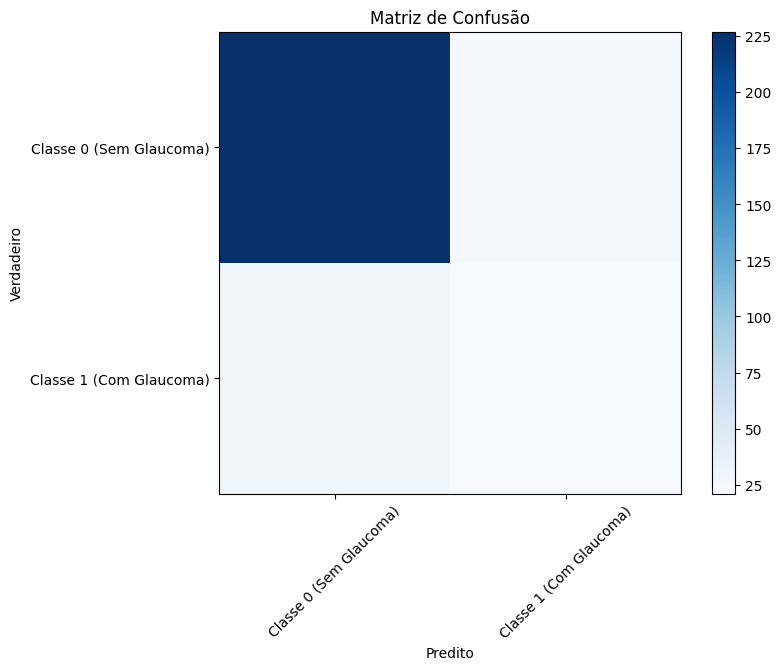

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.89      0.91      0.90       250
Classe 1 (Com Glaucoma)       0.48      0.42      0.45        50

               accuracy                           0.83       300
              macro avg       0.68      0.66      0.67       300
           weighted avg       0.82      0.83      0.82       300



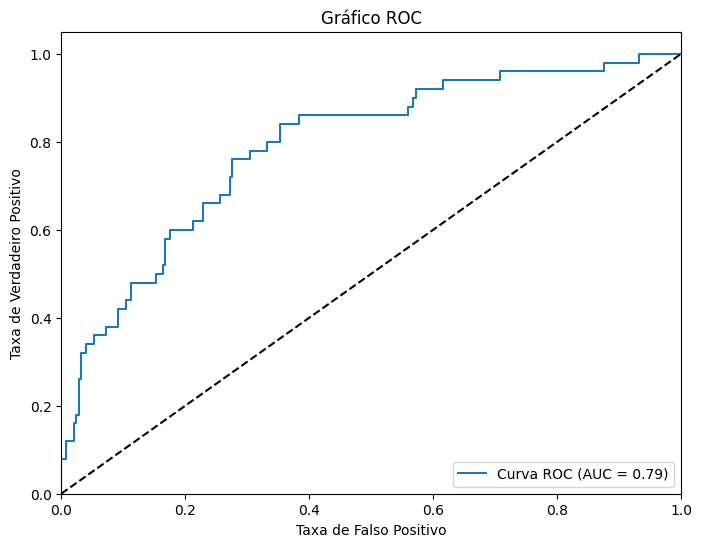

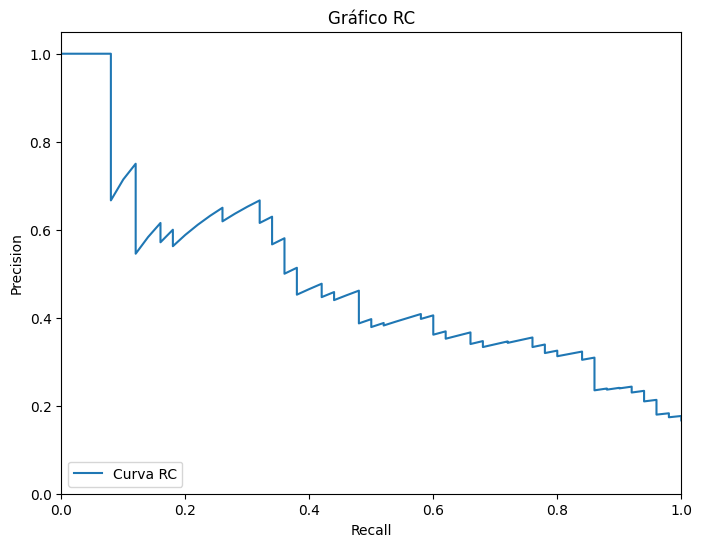

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.89      0.91      0.90       250
Classe 1 (Com Glaucoma)       0.48      0.42      0.45        50

               accuracy                           0.83       300
              macro avg       0.68      0.66      0.67       300
           weighted avg       0.82      0.83      0.82       300



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3], Train Accuracy: 78.88%, Validation Accuracy: 83.33%, Loss: 0.6049
Epoch [2/3], Train Accuracy: 88.93%, Validation Accuracy: 85.00%, Loss: 0.3714
Epoch [3/3], Train Accuracy: 95.74%, Validation Accuracy: 88.33%, Loss: 0.2252
Acurácia: 0.8033333333333333
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
True Negative (TN): 241
False Positive (FP): 9
False Negative (FN): 50
True Positive (TP): 0


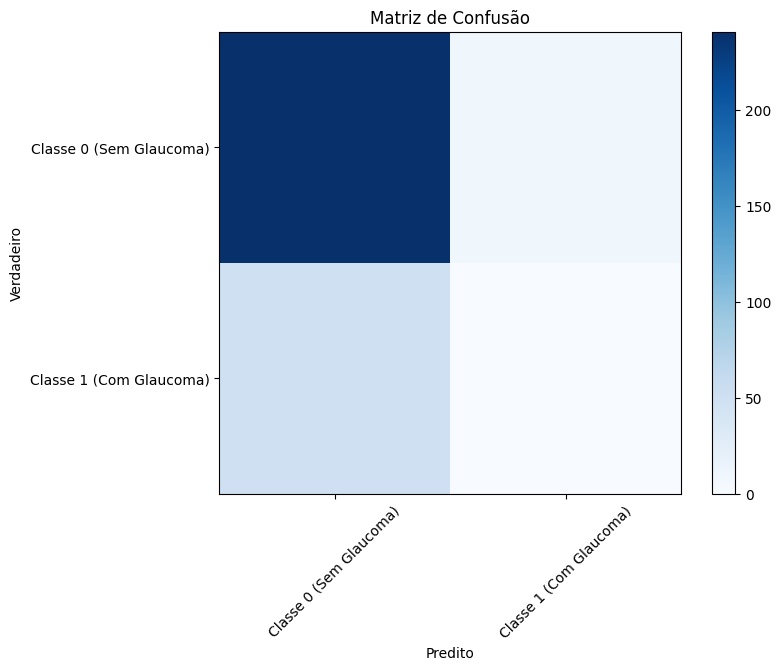

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      0.96      0.89       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.80       300
              macro avg       0.41      0.48      0.45       300
           weighted avg       0.69      0.80      0.74       300



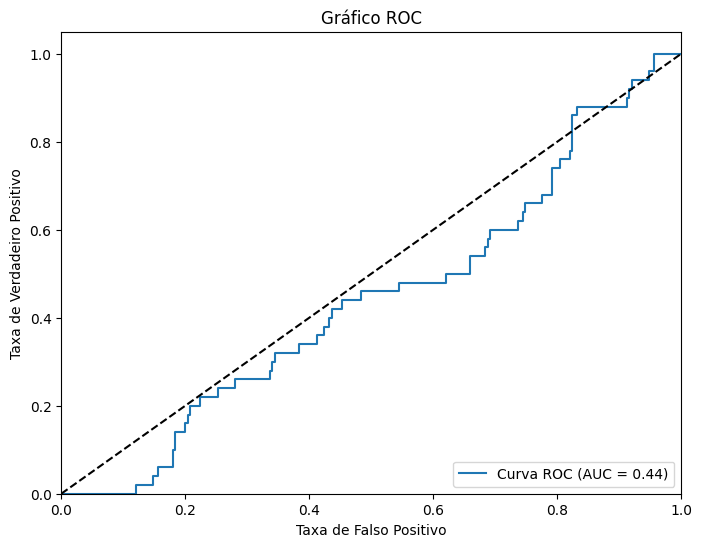

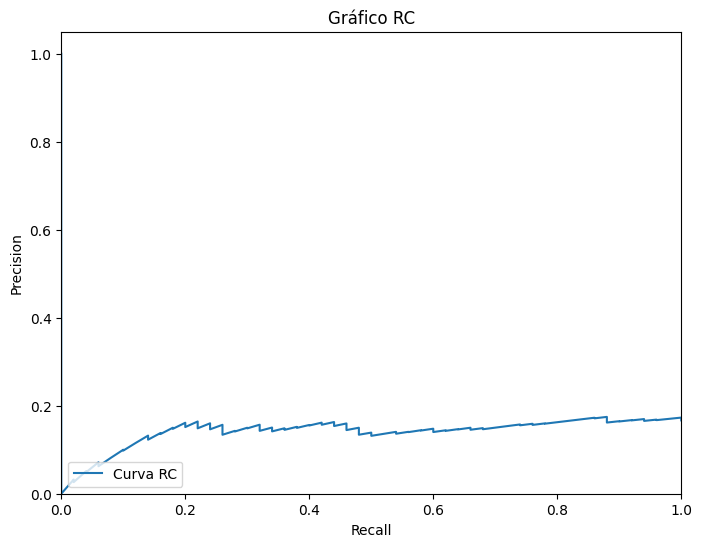

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      0.96      0.89       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.80       300
              macro avg       0.41      0.48      0.45       300
           weighted avg       0.69      0.80      0.74       300



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3], Train Accuracy: 92.91%, Validation Accuracy: 83.33%, Loss: 0.4289
Epoch [2/3], Train Accuracy: 94.66%, Validation Accuracy: 83.33%, Loss: 0.2027
Epoch [3/3], Train Accuracy: 96.75%, Validation Accuracy: 83.33%, Loss: 0.1229
Acurácia: 0.83
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
True Negative (TN): 249
False Positive (FP): 1
False Negative (FN): 50
True Positive (TP): 0


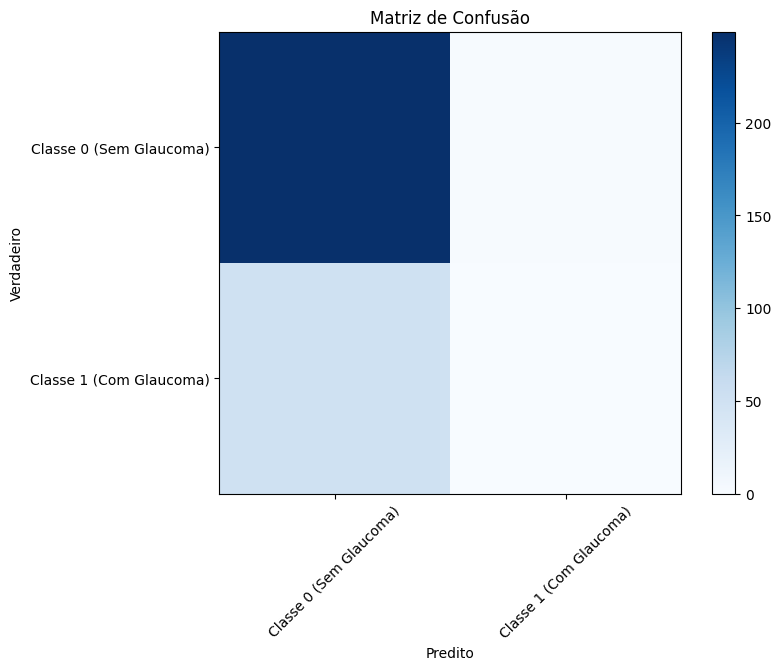

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      1.00      0.91       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.83       300
              macro avg       0.42      0.50      0.45       300
           weighted avg       0.69      0.83      0.76       300



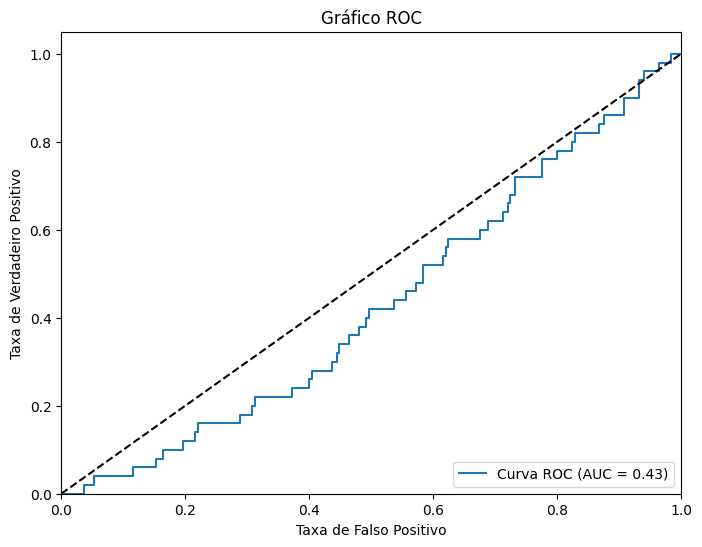

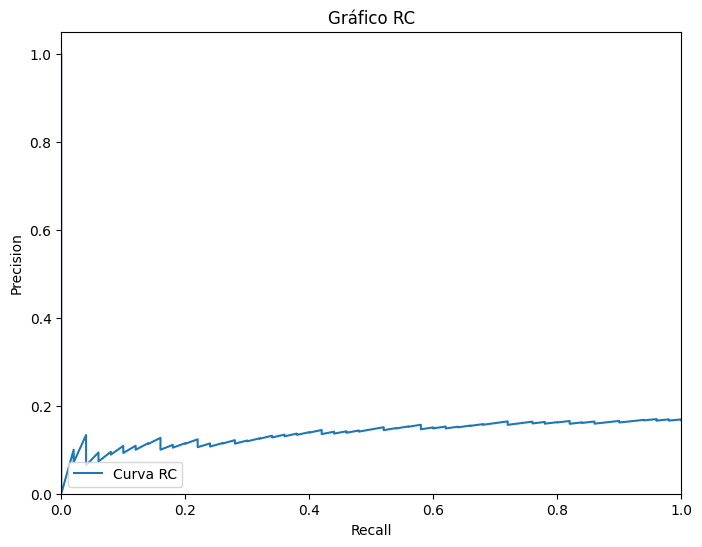

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      1.00      0.91       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.83       300
              macro avg       0.42      0.50      0.45       300
           weighted avg       0.69      0.83      0.76       300



In [ ]:
#Resnet novo COM VALIDAÇÃO como função e caminho adequado 3 em 1 Backup

import os
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Função para carregar as imagens e anotações
def load_data(root_dir):
    image_dir_train = os.path.join(root_dir, 'train/images')
    annotation_dir_train = os.path.join(root_dir, 'train/anotacoes')


    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(
        root=image_dir_train,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=16,
        shuffle=True
    )
    return train_loader

def test_load_data(root_dir):
    image_dir_test = os.path.join(root_dir, 'test/images')
    annotation_dir_test = os.path.join(root_dir, 'test/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])
    test_data = torchvision.datasets.ImageFolder(
        root=image_dir_test,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=16,
        shuffle=False
    )

    return test_loader

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def validation_load_data(root_dir):  # Corrigir o nome do parâmetro para root_dir
    image_dir_val = os.path.join(root_dir, 'valid/images')
    annotation_dir_val = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    val_data = torchvision.datasets.ImageFolder(
        root=image_dir_val,
        transform=transform
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=16,
        shuffle=False
    )

    return val_loader

def train_model(train_loader, val_loader, num_epochs,MODELO):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0  # Track the best test accuracy
    train_accuracies = []  # List to store train accuracies
    train_losses = []  # List to store train losses

    best_val_accuracy = 0.0  # Track the best validation accuracy
    val_accuracies = []  # List to store validation accuracies



    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        # Validation after each epoch
        model.eval()
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2%}, Validation Accuracy: {val_accuracy:.2%}, Loss: {epoch_loss:.4f}')

        # Save the best model based on the highest validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

    # Save the best model checkpoint
    torch.save(best_model_state, MODELO)

    return model


def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo de execução
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Obter as probabilidades de saída (scores)
            scores = F.softmax(outputs, dim=1)
            y_scores.extend(scores[:, 1].cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    class_names = ['Classe 0 (Sem Glaucoma)', 'Classe 1 (Com Glaucoma)']

    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular as estatísticas ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot do gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Gráfico ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular as estatísticas RC
    precision, recall, thresholds_rc = precision_recall_curve(y_true, y_scores)

    # Plot do gráfico RC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Curva RC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Gráfico RC')
    plt.legend(loc='lower left')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))


Valid_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/ORIGA/"
Teste_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
num_epochs = 3

Val_loader = validation_load_data(Valid_root)
Test_loader = test_load_data(Teste_root)

# Carregar os dados para G1020
TrainG1020_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
Train_loader_G1020 = load_data(TrainG1020_root)
G1020M = 'G1020best_model.pth'
modelo_G1020 = train_model(Train_loader_G1020, Val_loader, num_epochs,G1020M)
melhor_estado_modelo_G1020 = torch.load(G1020M)
modelo_G1020.load_state_dict(melhor_estado_modelo_G1020)
test_model(modelo_G1020, Test_loader)

# Carregar os dados para ORIGA
TrainORIGA_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/ORIGA/"
train_loader_ORIGA = load_data(TrainORIGA_root)
ORIGM = 'ORIGAbest_model.pth'
modelo_ORIGA = train_model(train_loader_ORIGA, Val_loader, num_epochs,ORIGM)
melhor_estado_modelo_ORIGA = torch.load(ORIGM)
modelo_ORIGA.load_state_dict(melhor_estado_modelo_ORIGA)
test_model(modelo_ORIGA, Test_loader)

# Carregar os dados para REFUGE
TrainREFUGE_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/REFUGE/"
train_loader_REFUGE = load_data(TrainREFUGE_root)
REFUM = 'REFUGEbest_model.pth'
modelo_REFUGE = train_model(train_loader_REFUGE, Val_loader, num_epochs,REFUM)
melhor_estado_modelo_REFUGE = torch.load('REFUGEbest_model.pth')
modelo_REFUGE.load_state_dict(melhor_estado_modelo_REFUGE)
test_model(modelo_REFUGE, Test_loader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.7MB/s]


Epoch [1/5], Train Accuracy: 71.78%, Validation Accuracy: 83.33%, Loss: 0.6424
Epoch [2/5], Train Accuracy: 72.49%, Validation Accuracy: 83.89%, Loss: 0.5736
Epoch [3/5], Train Accuracy: 78.07%, Validation Accuracy: 65.00%, Loss: 0.5459
Epoch [4/5], Train Accuracy: 78.58%, Validation Accuracy: 82.78%, Loss: 0.5087
Epoch [5/5], Train Accuracy: 80.91%, Validation Accuracy: 80.56%, Loss: 0.4835
Acurácia: 0.88
Precisão: 0.8888888888888888
Recall: 0.32
F1-score: 0.47058823529411764
True Negative (TN): 248
False Positive (FP): 2
False Negative (FN): 34
True Positive (TP): 16


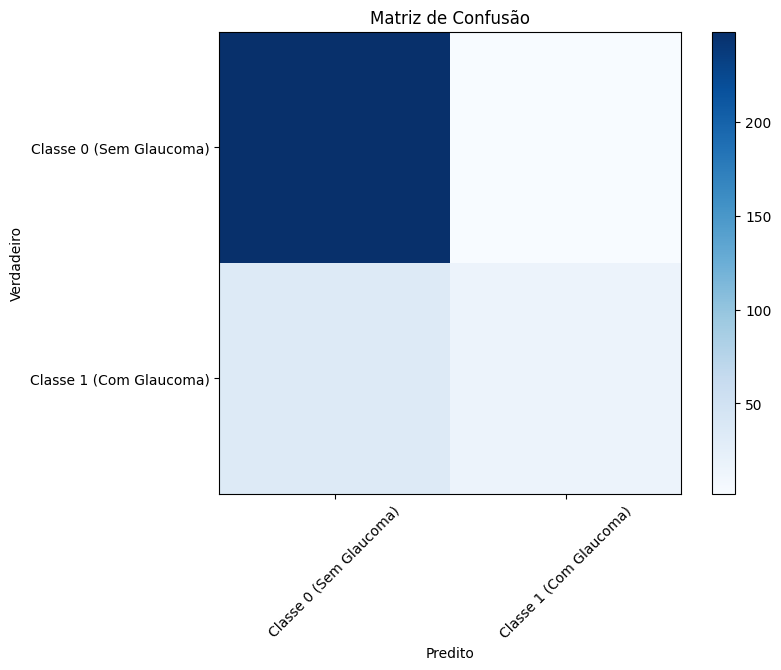

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.88      0.99      0.93       250
Classe 1 (Com Glaucoma)       0.89      0.32      0.47        50

               accuracy                           0.88       300
              macro avg       0.88      0.66      0.70       300
           weighted avg       0.88      0.88      0.86       300



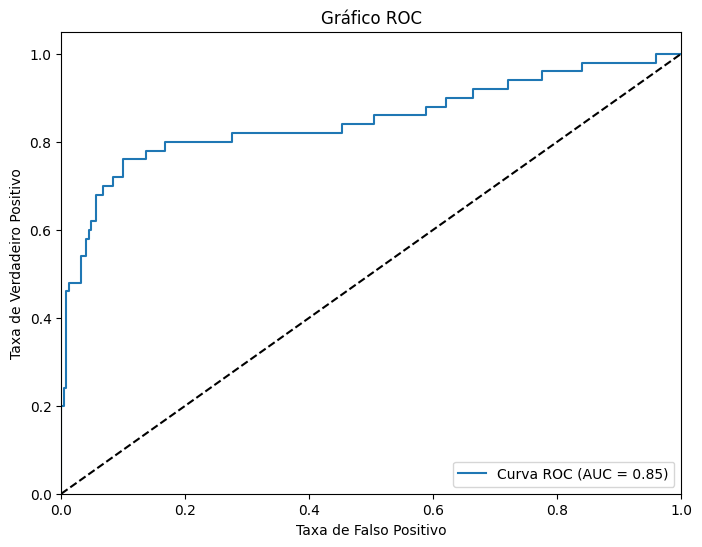

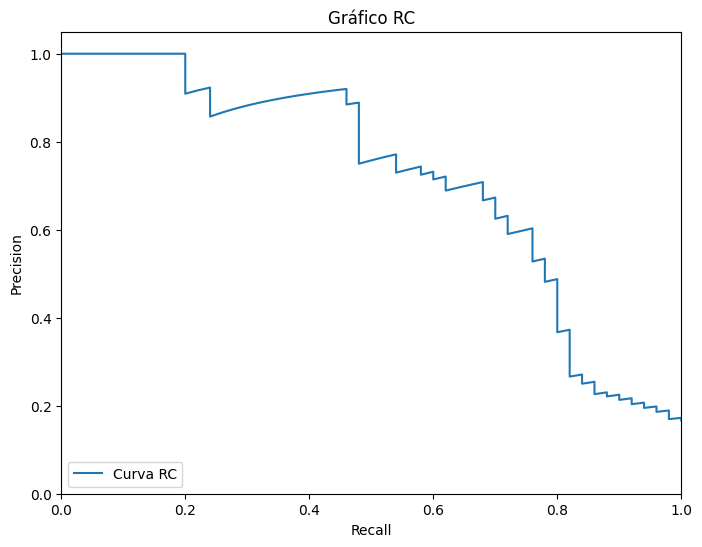

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.88      0.99      0.93       250
Classe 1 (Com Glaucoma)       0.89      0.32      0.47        50

               accuracy                           0.88       300
              macro avg       0.88      0.66      0.70       300
           weighted avg       0.88      0.88      0.86       300



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Train Accuracy: 76.15%, Validation Accuracy: 83.33%, Loss: 0.5386
Epoch [2/5], Train Accuracy: 82.96%, Validation Accuracy: 85.56%, Loss: 0.4549
Epoch [3/5], Train Accuracy: 83.13%, Validation Accuracy: 83.89%, Loss: 0.4190
Epoch [4/5], Train Accuracy: 87.39%, Validation Accuracy: 86.11%, Loss: 0.3748
Epoch [5/5], Train Accuracy: 90.80%, Validation Accuracy: 86.11%, Loss: 0.3385
Acurácia: 0.8133333333333334
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
True Negative (TN): 244
False Positive (FP): 6
False Negative (FN): 50
True Positive (TP): 0


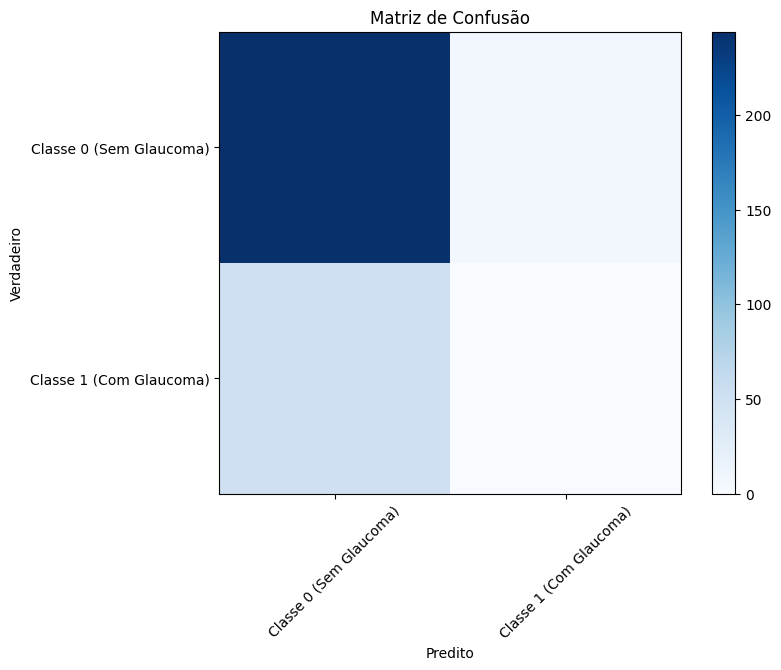

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      0.98      0.90       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.81       300
              macro avg       0.41      0.49      0.45       300
           weighted avg       0.69      0.81      0.75       300



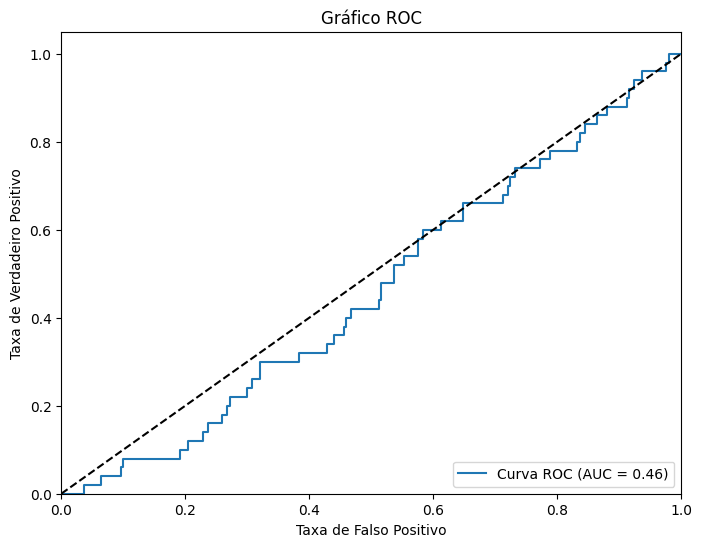

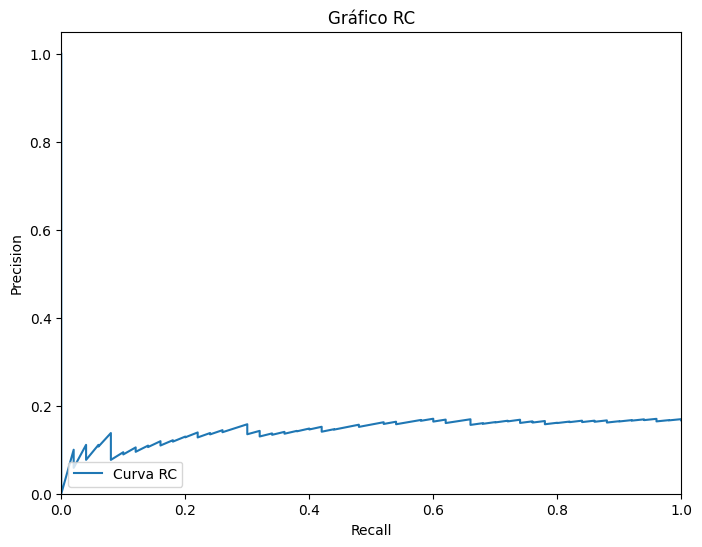

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      0.98      0.90       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.81       300
              macro avg       0.41      0.49      0.45       300
           weighted avg       0.69      0.81      0.75       300



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Train Accuracy: 90.16%, Validation Accuracy: 83.33%, Loss: 0.3268
Epoch [2/5], Train Accuracy: 91.49%, Validation Accuracy: 83.33%, Loss: 0.2786
Epoch [3/5], Train Accuracy: 91.24%, Validation Accuracy: 83.33%, Loss: 0.2492
Epoch [4/5], Train Accuracy: 92.58%, Validation Accuracy: 83.33%, Loss: 0.2273
Epoch [5/5], Train Accuracy: 94.25%, Validation Accuracy: 83.33%, Loss: 0.2054
Acurácia: 0.82
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
True Negative (TN): 246
False Positive (FP): 4
False Negative (FN): 50
True Positive (TP): 0


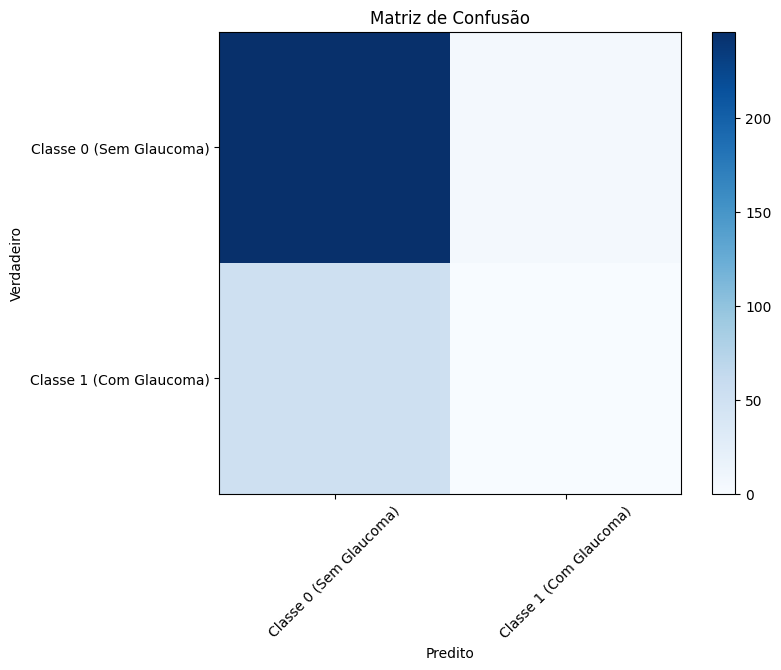

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      0.98      0.90       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.82       300
              macro avg       0.42      0.49      0.45       300
           weighted avg       0.69      0.82      0.75       300



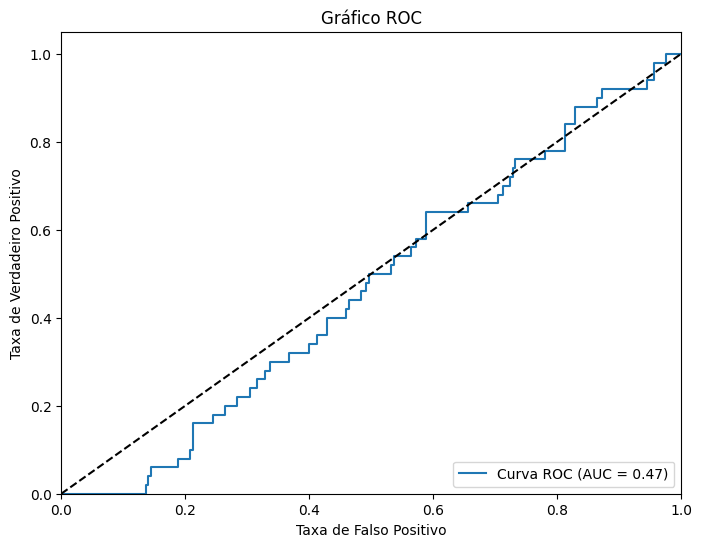

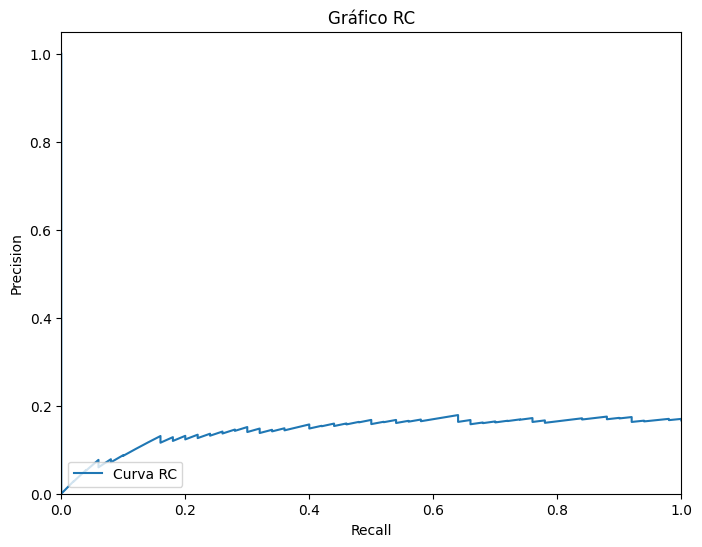

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.83      0.98      0.90       250
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        50

               accuracy                           0.82       300
              macro avg       0.42      0.49      0.45       300
           weighted avg       0.69      0.82      0.75       300



In [4]:
#Testeeeee

import os
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Função para carregar as imagens e anotações
def load_data(root_dir):
    image_dir_train = os.path.join(root_dir, 'train/images')
    annotation_dir_train = os.path.join(root_dir, 'train/anotacoes')


    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(
        root=image_dir_train,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=16,
        shuffle=True
    )
    return train_loader

def test_load_data(root_dir):
    image_dir_test = os.path.join(root_dir, 'test/images')
    annotation_dir_test = os.path.join(root_dir, 'test/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionar todas as imagens para o tamanho 224x224
        transforms.ToTensor()
    ])
    test_data = torchvision.datasets.ImageFolder(
        root=image_dir_test,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=16,
        shuffle=False
    )

    return test_loader

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def validation_load_data(root_dir):  # Corrigir o nome do parâmetro para root_dir
    image_dir_val = os.path.join(root_dir, 'valid/images')
    annotation_dir_val = os.path.join(root_dir, 'valid/anotacoes')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    val_data = torchvision.datasets.ImageFolder(
        root=image_dir_val,
        transform=transform
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=16,
        shuffle=False
    )

    return val_loader

def train_model(train_loader, val_loader, num_epochs,MODELO):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

    best_accuracy = 0.0  # Track the best test accuracy
    train_accuracies = []  # List to store train accuracies
    train_losses = []  # List to store train losses

    best_val_accuracy = 0.0  # Track the best validation accuracy
    val_accuracies = []  # List to store validation accuracies



    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        # Validation after each epoch
        model.eval()
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2%}, Validation Accuracy: {val_accuracy:.2%}, Loss: {epoch_loss:.4f}')

        # Save the best model based on the highest validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

    # Save the best model checkpoint
    torch.save(best_model_state, MODELO)

    return model


def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define o dispositivo de execução
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Obter as probabilidades de saída (scores)
            scores = F.softmax(outputs, dim=1)
            y_scores.extend(scores[:, 1].cpu().numpy())

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    print("True Negative (TN):", tn)
    print("False Positive (FP):", fp)
    print("False Negative (FN):", fn)
    print("True Positive (TP):", tp)
    class_names = ['Classe 0 (Sem Glaucoma)', 'Classe 1 (Com Glaucoma)']

    # Plot da matriz de confusão
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calcular as estatísticas ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot do gráfico ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Gráfico ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular as estatísticas RC
    precision, recall, thresholds_rc = precision_recall_curve(y_true, y_scores)

    # Plot do gráfico RC
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Curva RC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Gráfico RC')
    plt.legend(loc='lower left')
    plt.show()

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))


Valid_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/ORIGA/"
Teste_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
num_epochs = 5

Val_loader = validation_load_data(Valid_root)
Test_loader = test_load_data(Teste_root)

# Carregar os dados para G1020
TrainG1020_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/G1020/"
Train_loader_G1020 = load_data(TrainG1020_root)
G1020M = 'G1020best_model.pth'
modelo_G1020 = train_model(Train_loader_G1020, Val_loader, num_epochs,G1020M)
melhor_estado_modelo_G1020 = torch.load(G1020M)
modelo_G1020.load_state_dict(melhor_estado_modelo_G1020)
test_model(modelo_G1020, Test_loader)

# Carregar os dados para ORIGA
TrainORIGA_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/ORIGA/"
train_loader_ORIGA = load_data(TrainORIGA_root)
ORIGM = 'ORIGAbest_model.pth'
modelo_ORIGA = train_model(train_loader_ORIGA, Val_loader, num_epochs,ORIGM)
melhor_estado_modelo_ORIGA = torch.load(ORIGM)
modelo_ORIGA.load_state_dict(melhor_estado_modelo_ORIGA)
test_model(modelo_ORIGA, Test_loader)

# Carregar os dados para REFUGE
TrainREFUGE_root = "/content/drive/MyDrive/compara_segmentadores/data2/talho/REFUGE/"
train_loader_REFUGE = load_data(TrainREFUGE_root)
REFUM = 'REFUGEbest_model.pth'
modelo_REFUGE = train_model(train_loader_REFUGE, Val_loader, num_epochs,REFUM)
melhor_estado_modelo_REFUGE = torch.load('REFUGEbest_model.pth')
modelo_REFUGE.load_state_dict(melhor_estado_modelo_REFUGE)
test_model(modelo_REFUGE, Test_loader)


Epoch [1/3], Train Accuracy: 90.00%, Validation Accuracy: 47.83%, Loss: 0.5826
Epoch [2/3], Train Accuracy: 95.50%, Validation Accuracy: 47.83%, Loss: 0.1842
Epoch [3/3], Train Accuracy: 98.25%, Validation Accuracy: 52.17%, Loss: 0.0718


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia: 0.6
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
True Negative (TN): 21
False Positive (FP): 0
False Negative (FN): 14
True Positive (TP): 0


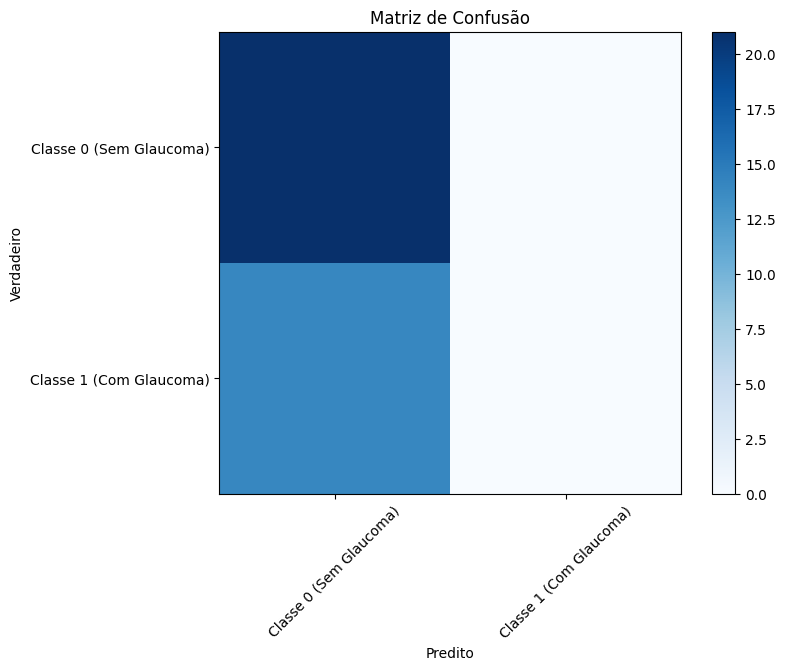

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.60      1.00      0.75        21
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        14

               accuracy                           0.60        35
              macro avg       0.30      0.50      0.37        35
           weighted avg       0.36      0.60      0.45        35



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


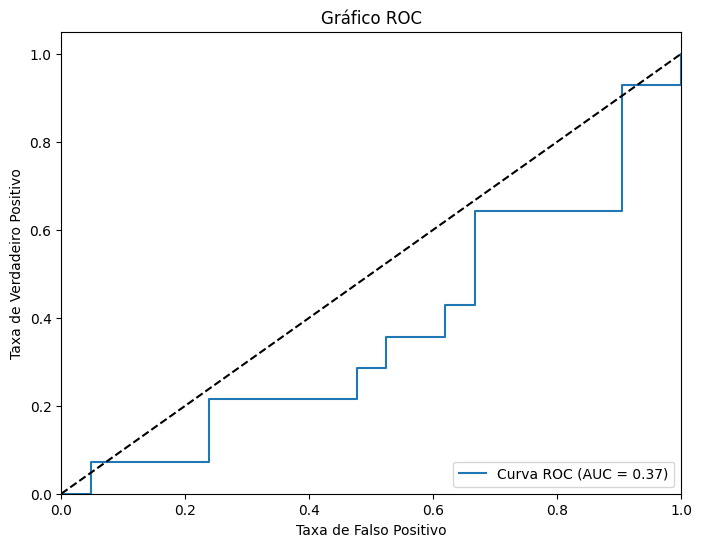

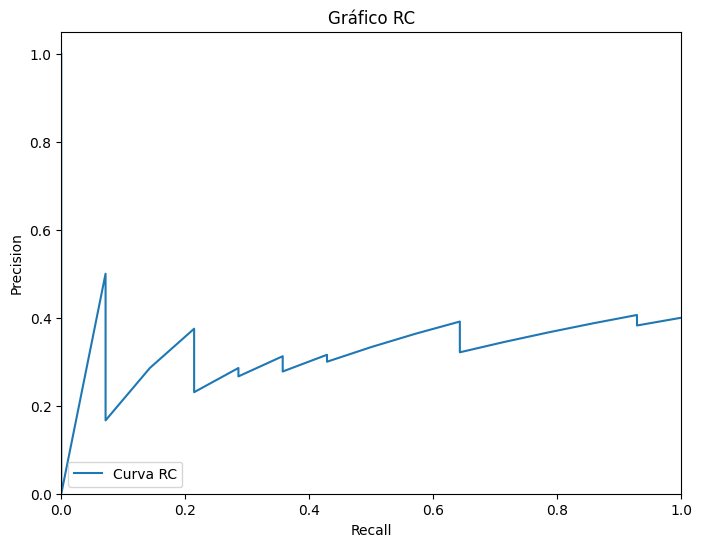

Relatório de Classificação:
                         precision    recall  f1-score   support

Classe 0 (Sem Glaucoma)       0.60      1.00      0.75        21
Classe 1 (Com Glaucoma)       0.00      0.00      0.00        14

               accuracy                           0.60        35
              macro avg       0.30      0.50      0.37        35
           weighted avg       0.36      0.60      0.45        35



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Carregar os dados para REFUGE
root_dir_REFUGE = "/content/drive/MyDrive/compara_segmentadores/data2/talho/REFUGE/"
train_loader_REFUGE = load_data(root_dir_REFUGE)
val_root_dir_REFUGE = "/content/drive/MyDrive/compara_segmentadores/data2/talho/ORIGA/"
val_loader_REFUGE = validation_load_data(val_root_dir_REFUGE)
REFUM = 'REFUGEbest_model.pth'
modelo_REFUGE = train_model(train_loader_REFUGE, val_loader_REFUGE, num_epochs,REFUM)
melhor_estado_modelo_REFUGE = torch.load('REFUGEbest_model.pth')
modelo_REFUGE.load_state_dict(melhor_estado_modelo_REFUGE)
test_loader_REFUGE = test_load_data(root_dir_g1020)
test_model(modelo_REFUGE, test_loader_REFUGE)